In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage import transform
from scipy.ndimage.filters import gaussian_laplace, convolve
from scipy.ndimage.filters import rank_filter, generic_filter
from scipy.misc import imresize
import time
import math
from itertools import chain

In [2]:
def load_and_preprocess(path):
    # Load image.
    img = io.imread(path)
    # Gray and scale.
    img = color.rgb2gray(img)
    img /= 255
    return img

In [3]:
# Get squared Laplacian response in scale-space.
def get_scale_space(image, init_sigma, levels, k, method):
    sigma = np.zeros(levels)
    sigma[0] = init_sigma
    
    h = image.shape[0]
    w = image.shape[1]
    
    scale_space = np.empty((h, w, levels))
    
    # Method 1. (slower version)
    def increase_filter_size():
        for i in range(levels):
            # Ensure odd filter size.
            filter_size = int(round(6 * sigma[i]))
            if filter_size % 2 == 0:
                filter_size += 1

            # Initialize filter matrix.
            center = int((filter_size + 1)/2 - 1)  # index of center entry
            gauss_filter = np.zeros((filter_size, filter_size))
            gauss_filter[center][center] = 1

            # Obtain filter with normalization and apply convolution.
            LoG = sigma[i]*sigma[i]*gaussian_laplace(gauss_filter, sigma[i])
            scale_space[:,:,i] = convolve(image, LoG) ** 2

            # Update sigma.
            if (i+1 < levels):
                sigma[i+1] = sigma[i] * k
    
    # Method 2. (faster version)
    def downsample():
        # Ensure odd filter size.
        filter_size = int(round(6 * sigma[0]))
        if filter_size % 2 == 0:
            filter_size += 1
        
        # Initialize filter matrix.
        center = int((filter_size + 1)/2 - 1)  # index of center entry
        gauss_filter = np.zeros((filter_size, filter_size))
        gauss_filter[center][center] = 1
        
        # Obtain filter (no normalization needed).
        LoG = gaussian_laplace(gauss_filter, sigma[0])
        
        # Scale the image.
        for i in range(levels):
            # Down scale.
            scaled_h = int(h * ((1/k) ** i))
            scaled_w = int(w * ((1/k) ** i))
            # scaled_im = transform.resize(image, (scaled_h, scaled_w), order=3)
            scaled_im = transform.rescale(image, (1/k) ** i, order=3)
            
            # Apply convolution without normalization.
            im_tmp = convolve(scaled_im, LoG) ** 2
            
            # Upscale.
            scale_space[:,:,i] = transform.resize(im_tmp, (h, w), order=3)
            
            # Update sigma.
            if (i+1 < levels):
                sigma[i+1] = sigma[i] * k

    # Run method and record time.
    print('Calculating squared Laplacian response in scale-space...')
    
    start = time.time()
    run = {'increase_filter_size': increase_filter_size, 
           'downsample': downsample}
    run[method]()
    end = time.time()
    
    print('Method used: ' + method + 
          '; Time elapsed: {} s.'.format(end-start))

    return scale_space, sigma

In [4]:
# Helper func: non-maximum suppression in each 2D slice.
def non_max_sup_2D(scale_space, method):
    h = scale_space.shape[0]
    w = scale_space.shape[1]
    levels = scale_space.shape[2]
    
    local_max = np.empty((h, w, levels))
    
    # Method 1: rank_filter.
    # This method is much faster. Use this.
    def rank():
        for i in range(levels):
            curr_response = scale_space[:,:,i]
            local_max[:,:,i] = rank_filter(curr_response, -1, (3,3))
    
    # Method 2: generic_filter.
    def generic():
        for i in range(levels):
            curr_response = scale_space[:,:,i]
            
            find_max = lambda arr:np.amax(arr)
            local_max[:,:,i] = generic_filter(curr_response, find_max, (3,3))
    
    # Run method and record time.
    print('Running local non-max suppression...')
    
    start = time.time()
    run = {'rank': rank, 'generic': generic}
    run[method]()
    end = time.time()
    
    print('Method used: ' + method + 
          '; Time elapsed: {} s.'.format(end-start))
    
    return local_max

In [5]:
# Helper func: compute radius of each local maximum.
def get_radius(sigma, num_rads): 
    return np.ones(num_rads) * math.sqrt(2) * sigma

In [6]:
# Helper func: mask filter to eliminate boundaries noises.
def get_mask(h, w, levels, sigma):
    mask = np.zeros((h, w, levels))
    for i in range(levels):
        b = int(math.ceil(sigma[i] * math.sqrt(2)))  # Boundary.
        mask[b+1:h-b, b+1:w-b] = 1
    return mask

In [7]:
# Non-maximum suppression in 3D scale space.
def non_max_sup_3D(scale_space, sigma):
    
    # Obtain local 2D non max sup using rank_filter.
    local_max = non_max_sup_2D(scale_space, 'rank')
    
    h = local_max.shape[0]
    w = local_max.shape[1]
    levels = local_max.shape[2]
    
    # Compute non-max suppression accorss all layers.
    print("Running global non-max suppression...")
    global_max = np.zeros(local_max.shape)
    
    for i in range(h):
        for j in range(w):
            max_value = np.amax(local_max[i,j,:])
            max_idx = np.argmax(local_max[i,j,:])
            global_max[i,j,max_idx] = max_value
    
    # Eliminate duplicate values.
    for i in range(levels):
        global_max[:,:,i] = np.where((global_max[:,:,i] == 
                                      scale_space[:,:,i]), 
                                     global_max[:,:,i], 0)
    

    print("Done with global non-max suppression.")
    return global_max

In [8]:
# Obtain center points and radius of blobs.
def detect_blob(global_max, threshold, sigma):
    levels = global_max.shape[2]
    
    mask = get_mask(global_max.shape[0], 
                    global_max.shape[1], 
                    levels, sigma)
    
    row_idx = []
    col_idx = []
    radius = []
    
    print('Finding blobs...')
    for i in range(levels):
        global_max[:,:,i] = np.where((global_max[:,:,i] > threshold) & 
                                     (mask[:,:,i] == 1), 1, 0)
        
        # Obtain row & column index for local maxima.
        row_idx.append(list(np.where(global_max[:,:,i] == 1)[0]))
        col_idx.append(list(np.where(global_max[:,:,i] == 1)[1]))
        
        # Compute radius.
        radius.append(list(get_radius(sigma[i], len(row_idx[i]))))
    
    # Flatten nested list.
    row_idx = list(chain.from_iterable(row_idx))
    col_idx = list(chain.from_iterable(col_idx))
    radius = list(chain.from_iterable(radius))
    
    print('Done with finding blobs.')
    return row_idx, col_idx, radius

In [9]:
def show_and_save_all_circles(image, cx, cy, rad, 
                              root, img_name, method, threshold, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    import matplotlib.pyplot as plt
    from matplotlib.patches import Circle

    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    
    plt.savefig(root+img_name+'_'
                +method+'_'+str(threshold)+'.svg', format='svg')
    
    plt.show()

In [10]:
# Pipeline for running the whole program.
def run_detection(root, img_name, method, levels, k, threshold, init_sigma):
    # Load and preprocess image.
    path = root+img_name+'.jpg'
    img = load_and_preprocess(path)
    
    # Get response.
    scale_space, sigma = get_scale_space(img, init_sigma, levels, k, method)
    
    # Non-max suppression.
    global_max = non_max_sup_3D(scale_space, sigma)
    
    # Get blobs.
    row_idx, col_idx, radius = detect_blob(global_max, threshold, sigma)
    
    # Display and save output.
    show_and_save_all_circles(img, col_idx, row_idx, radius, 
                              root, img_name, method, threshold)

# Configurations

In [11]:
root = 'assignment2_images/'

# Choose one image.
images = ['butterfly', 'einstein', 'fishes', 'sunflowers', 'martin', 'cat', 'roman', 'car']
# Choose one method.
methods = ['increase_filter_size', 'downsample']

# Configure parameters.
levels = 12  # Scale levels
k = 1.25  # Scale factor
init_sigma = 2 

# Good thresholds for method 0 and 1.
thresholds = np.array([0.0000001, 0.000000008])

# Detect on `butterfly`

Calculating squared Laplacian response in scale-space...
Method used: increase_filter_size; Time elapsed: 30.933618783950806 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.07532691955566406 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


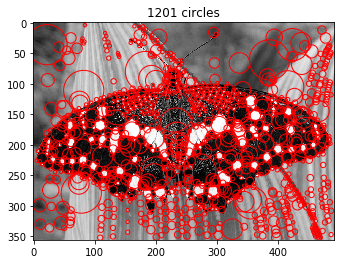

In [12]:
run_detection(root, images[0], methods[0], levels, k, thresholds[0], init_sigma)

Calculating squared Laplacian response in scale-space...


/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Method used: downsample; Time elapsed: 0.43922996520996094 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.07020902633666992 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


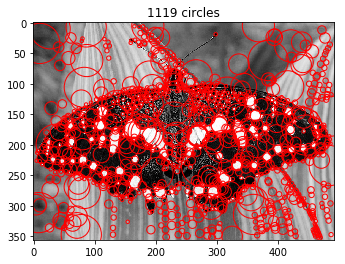

In [13]:
run_detection(root, images[0], methods[1], levels, k, thresholds[1], init_sigma)

# Detect on `einstein`

Calculating squared Laplacian response in scale-space...
Method used: increase_filter_size; Time elapsed: 37.035035133361816 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.11284112930297852 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


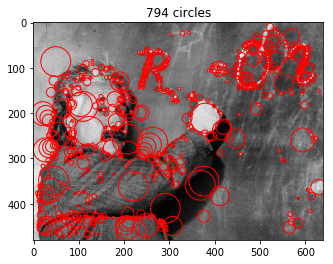

In [14]:
run_detection(root, images[1], methods[0], levels, k, thresholds[0], init_sigma)

Calculating squared Laplacian response in scale-space...


/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Method used: downsample; Time elapsed: 0.7940258979797363 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.12715506553649902 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


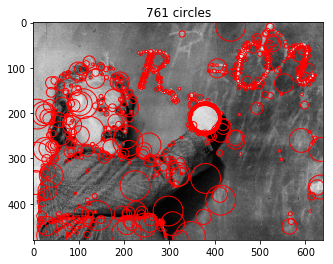

In [15]:
run_detection(root, images[1], methods[1], levels, k, thresholds[1], init_sigma)

# Detect on `fishes`

Calculating squared Laplacian response in scale-space...
Method used: increase_filter_size; Time elapsed: 28.032413244247437 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.05839204788208008 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


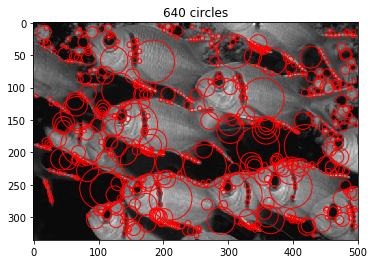

In [16]:
run_detection(root, images[2], methods[0], levels, k, thresholds[0], init_sigma)

Calculating squared Laplacian response in scale-space...


/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Method used: downsample; Time elapsed: 0.44306516647338867 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.046035051345825195 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


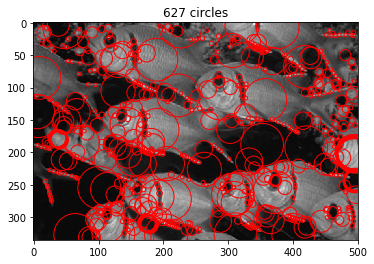

In [17]:
run_detection(root, images[2], methods[1], levels, k, thresholds[1], init_sigma)

# Detect on `sunflowers`

Calculating squared Laplacian response in scale-space...
Method used: increase_filter_size; Time elapsed: 25.306132793426514 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.047209978103637695 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


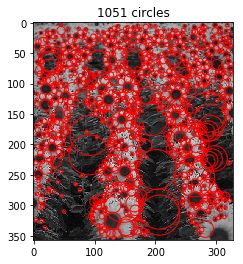

In [31]:
run_detection(root, images[3], methods[0], levels, k, 0.00000018, init_sigma)

Calculating squared Laplacian response in scale-space...


/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Method used: downsample; Time elapsed: 0.3230741024017334 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.04061603546142578 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


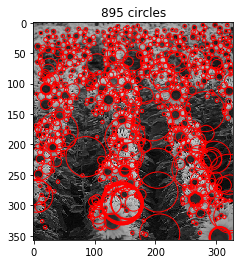

In [32]:
run_detection(root, images[3], methods[1], levels, k, 0.000000015, init_sigma)

# Detect on `martin`

Calculating squared Laplacian response in scale-space...
Method used: increase_filter_size; Time elapsed: 45.05645203590393 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.14860224723815918 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


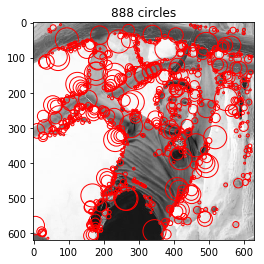

In [20]:
run_detection(root, images[4], methods[0], levels, k, thresholds[0], init_sigma)

Calculating squared Laplacian response in scale-space...


/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Method used: downsample; Time elapsed: 0.8989887237548828 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.15458893775939941 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


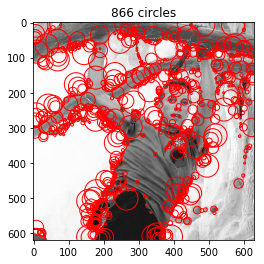

In [21]:
run_detection(root, images[4], methods[1], levels, k, thresholds[1], init_sigma)

# Detect on `cat`

Calculating squared Laplacian response in scale-space...
Method used: increase_filter_size; Time elapsed: 81.8435730934143 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.3536100387573242 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


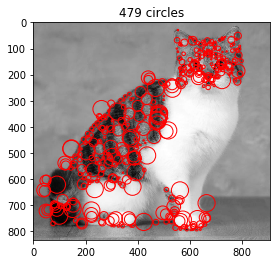

In [22]:
run_detection(root, images[5], methods[0], levels, k, thresholds[0], init_sigma)

Calculating squared Laplacian response in scale-space...


/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Method used: downsample; Time elapsed: 1.811655044555664 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.3140239715576172 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


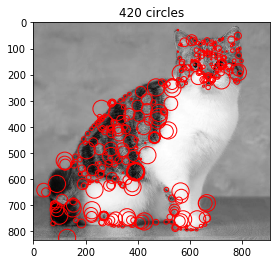

In [23]:
run_detection(root, images[5], methods[1], levels, k, thresholds[1], init_sigma)

# Detect on `roman`

Calculating squared Laplacian response in scale-space...
Method used: increase_filter_size; Time elapsed: 109.37071704864502 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.4226069450378418 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


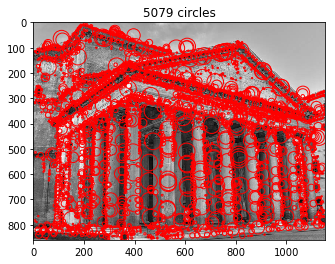

In [24]:
run_detection(root, images[6], methods[0], levels, k, 0.00000018, init_sigma)

Calculating squared Laplacian response in scale-space...


/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Method used: downsample; Time elapsed: 2.016057014465332 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.41530323028564453 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


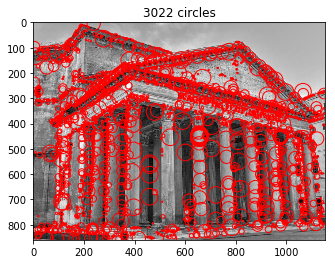

In [25]:
run_detection(root, images[6], methods[1], levels, k, 0.00000002, init_sigma)

# Detect on `car`

Calculating squared Laplacian response in scale-space...
Method used: increase_filter_size; Time elapsed: 140.50351786613464 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.6145451068878174 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


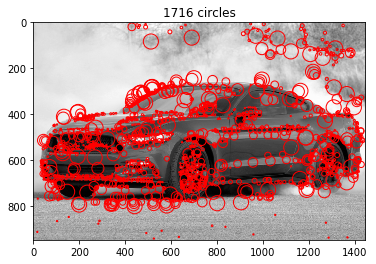

In [34]:
run_detection(root, images[7], methods[0], levels, k, thresholds[0], init_sigma)

Calculating squared Laplacian response in scale-space...


/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


Method used: downsample; Time elapsed: 3.099503993988037 s.
Running local non-max suppression...
Method used: rank; Time elapsed: 0.6068260669708252 s.
Running global non-max suppression...
Done with global non-max suppression.
Finding blobs...
Done with finding blobs.


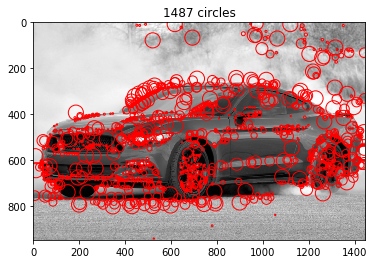

In [27]:
run_detection(root, images[7], methods[1], levels, k, thresholds[1], init_sigma)